# BDM Exam Project - Part 2

## DOMANDE X PROF:
TASK 4:

PARTE C:
- L'algoritmo di clustering spettrale si costruisce automaticamente la matrice laplaciana, possiamo usarlo o meno? (in ogni caso abbiamo descritto come si creerebbe)
<br>

TASK 5:
- Nel paper non c'è scritto nulla, possiamo usare Knn e decision-tree già scritti o dobbiamo scriverli di nostro? (in task 4 c'è scritto di scriverli da 0, qua no)
- I dati da clusterizzare possiamo già caricarli prima ed eseguire tutte le operazioni man mano? (words -> vettorizzazione -> ecc...)

## TODO:
TASK1
- Fixare LDA scrauso, bisogna capire che label passarci dato che è supervisionato!
<br>

TASK2
- Implementare Opzione #1
- Implementare Opzione (#2,#3 QUESTE DUE CONTROLLARE SE GIà FUNZIONA), (#4 ANCORA DA IMPLEMENTARE LDA)
- Implementare Opzione #5
- Implementare Opzione #6
<br>

TASK3
- punto 1) 4 opzioni di implementazioni co0me nel task2
- NOTA BENE: le 3 parti devono funzionare senza cambiare codice (indifferentemente da cosa abbiamo scelto prima, l'input per la parte 4 DEVE essere sempre lo stesso)
<br>

TASK4
- [x] DONE
<br>

TASK 5
- \[X] Leggere i veri dati di test
- [X] Parte A
- [X] Parte B 


## Imports

In [1]:
# General utils
import os
import shutil
import numpy as np

# per i plot
import plotly.express as px
import plotly.graph_objects as go
# ---------- ---------- ---------- ---------- ----------

# My general utils
from my_utils import get_files_name
# ---------- ---------- ---------- ---------- ----------

# Task 0
from task0_utils import task0_stats
# Parte A
from task0_utils import generate_alphabet
from task0_utils import gesture_2_word
from task0_utils import write_word_as_json
from task0_utils import generate_dizionario_parole_from_gesturewordsdict
# Parte B
from task0_utils import gesture_words_preprocessing
from task0_utils import show_gesture_metrics
# ---------- ---------- ---------- ---------- ----------

# Task 1
from task1_utils import read_gesture_measures_reduced
from task1_utils import metrics_reduced_2_numpy
from task1_utils import metrics_numpy_2_pandas
from task1_utils import metrics_numpy_2_PCA
from task1_utils import metrics_numpy_2_LDA
from task1_utils import metrics_numpy_2_SVD
from task1_utils import get_top_k_latent_features
from task1_utils import prepare_alg_variances_to_plot
# ---------- ---------- ---------- ---------- ----------

# Task 2
from task2_utils import find_k_most_similar
from task2_utils import generate_alg_database
# ---------- ---------- ---------- ---------- ----------

# Task 3
from task3_utils import generate_gestures_similarity_matrix
from task3_utils import gestures_similarity_matrix_2_pandas
from task3_utils import generate_gesture_gesture_svd
from task3_utils import get_top_p_latent_gestures
# ---------- ---------- ---------- ---------- ----------

# Task 4
from task4_utils import cluster_labels_2_pandas
from task4_utils import top_p_gestures_2_numpy
# Parte A
from task4_utils import MyPartitioner
# Parte B
from task4_utils import SimpleKMeans
# Parte C
from task4_utils import spectral_clustering_analyze
from task4_utils import spectral_analisys_results_2_pandas
from task4_utils import spectral_analisys_results_pandas_2_split
from task4_utils import spectral_clustering
# ---------- ---------- ---------- ---------- ----------

# Task 5
from task5_utils import database_numpy_2_supervised_data
from task5_utils import prepare_test_dataframe

from sklearn.preprocessing import StandardScaler
# KNN classifier
from sklearn.neighbors import KNeighborsClassifier
# Decision Tree classifier
from sklearn import tree
import graphviz 
# ---------- ---------- ---------- ---------- ----------

## Task 0

In [2]:
path_csv_directory = '../Dati_2/csv/'

In [3]:
path_words_directory = '../Dati_2/words/'

In [4]:
path_vectors_directory = '../Dati_2/vectors/'

Inserire le coordinate che compongono il gesto separate da un trattino:

In [5]:
input_data_components = 'X-Y-Z-W'

Inserire un valore per R (2R è il numero di simboli dell'alfabeto)

In [6]:
input_interval_resolution = '1'

In [7]:
data_components = input_data_components.strip().split("-")
task0_stats["r"] = int(input_interval_resolution.strip())


_RESET_DATA_ = True # se metto false non cancella le directory, se metto true devo rieseguire anche la parte 0 per rigenerare tutto
# Rigenero i vari file path (per words e vectors)
if _RESET_DATA_:
    if os.path.exists(path_words_directory):
        shutil.rmtree(path_words_directory)
    os.makedirs(path_words_directory)

    if os.path.exists(path_vectors_directory):
        shutil.rmtree(path_vectors_directory)
    os.makedirs(path_vectors_directory)

In [8]:
# Mi prendo il nome di tutti i files
gesture_files = get_files_name(path_csv_directory + "X/", ext_filter="csv")
alfabeto = generate_alphabet(gesture_files, data_components, path_csv_directory, task0_stats)

In [9]:
print(alfabeto.simboli)
print(alfabeto.parole)
print(alfabeto.n_simboli)
print(alfabeto.n_parole)

{'0.5': (0, 1.0), '-0.5': (0.0, -1.0)}
{'-0.5;-0.5', '0.5;0.5', '-0.5;0.5', '0.5;-0.5'}
2
4


### Task 0A

In [10]:
dizionario_gesti_parole = {}
for gesture_file_name in gesture_files:
    gesture_words_dict = gesture_2_word(gesture_file_name, data_components, alfabeto, path_csv_directory)
    # Salvo solo le info necessarie relative alle parole (come richiesto nel testo)
    dizionario_parole_gesture = generate_dizionario_parole_from_gesturewordsdict(gesture_words_dict)
    dizionario_gesti_parole[gesture_file_name.split(".")[0]] = dizionario_parole_gesture
    # Salvo su file il dizionario completo
    write_word_as_json(gesture_words_dict, gesture_file_name, path_words_directory)

In [11]:
dizionario_gesti_parole['1']

{('X', '0', '-0.5;-0.5'): 2,
 ('X', '1', '-0.5;-0.5'): 2,
 ('X', '2', '-0.5;-0.5'): 2,
 ('X', '3', '-0.5;-0.5'): 2,
 ('X', '4', '0.5;0.5'): 2,
 ('X', '5', '-0.5;-0.5'): 2,
 ('X', '6', '-0.5;-0.5'): 2,
 ('X', '7', '-0.5;-0.5'): 2,
 ('X', '8', '0.5;0.5'): 2,
 ('X', '9', '-0.5;-0.5'): 2,
 ('X', '10', '-0.5;-0.5'): 2,
 ('X', '11', '-0.5;-0.5'): 2,
 ('X', '12', '0.5;0.5'): 2,
 ('X', '13', '0.5;0.5'): 2,
 ('X', '14', '-0.5;-0.5'): 2,
 ('X', '15', '-0.5;-0.5'): 2,
 ('X', '16', '0.5;0.5'): 2,
 ('X', '17', '-0.5;-0.5'): 2,
 ('X', '18', '-0.5;-0.5'): 2,
 ('X', '19', '-0.5;-0.5'): 2,
 ('Y', '0', '-0.5;-0.5'): 2,
 ('Y', '1', '-0.5;-0.5'): 2,
 ('Y', '2', '-0.5;-0.5'): 2,
 ('Y', '3', '-0.5;-0.5'): 2,
 ('Y', '4', '0.5;0.5'): 2,
 ('Y', '5', '-0.5;-0.5'): 2,
 ('Y', '6', '-0.5;-0.5'): 2,
 ('Y', '7', '-0.5;-0.5'): 2,
 ('Y', '8', '0.5;0.5'): 2,
 ('Y', '9', '-0.5;-0.5'): 2,
 ('Y', '10', '-0.5;-0.5'): 2,
 ('Y', '11', '-0.5;-0.5'): 2,
 ('Y', '12', '0.5;0.5'): 2,
 ('Y', '13', '0.5;0.5'): 2,
 ('Y', '14', '-0.5

### Task 0B

In [12]:
# Mi prendo la lista di tutti i file words
words_files = get_files_name(path_words_directory, ext_filter="wrd")

# CALCOLARE IL NUMERO DI SENSORI (anche se so che ce ne sono 20, in questo modo rimane più parametrico)
n_sensori = 0
for (_, sensor, word), cont in dizionario_gesti_parole[next(iter(dizionario_gesti_parole))].items():
    sensor = int(sensor)
    if n_sensori > sensor: # ho già ciclato una volta su tutti i sensori, è inutile ricontrollare per le altre coordinate
        break
    if n_sensori < sensor:
        n_sensori = sensor
n_sensori += 1 # Correzione dato che i sensori partono da 0 e a me serve sapere quanti ce ne sono

t0b_preprocessing_settings = {
    'dizionario_gesti_parole': dizionario_gesti_parole,
    'data_components': data_components,
    'words_files': words_files,
    'n_sensori': n_sensori,
    'alfabeto': alfabeto,
    'path_words_directory': path_words_directory,
    'path_vectors_directory': path_vectors_directory # mettere a None o a caso se si mette save=False nel metodo
}
# Calcolo TF, IDF, TF-IDF di ogni gesto
gestures_metrics = gesture_words_preprocessing(t0b_preprocessing_settings)

In [13]:
show_gesture_metrics(gestures_metrics[0])

File gesto: ../Dati_2/words/9.wrd
Numero sensori: 20
TF: (2}
word: -0.5;-0.5 tf: {'0': 1.0, '1': 1.0, '2': 1.0, '3': 1.0, '4': 0, '5': 0.6667, '6': 1.0, '7': 1.0, '8': 0, '9': 1.0, '10': 1.0, '11': 1.0, '12': 0, '13': 0, '14': 1.0, '15': 1.0, '16': 0, '17': 1.0, '18': 1.0, '19': 1.0}
word: 0.5;0.5 tf: {'0': 0, '1': 0, '2': 0, '3': 0, '4': 1.0, '5': 0.3333, '6': 0, '7': 0, '8': 1.0, '9': 0, '10': 0, '11': 0, '12': 1.0, '13': 1.0, '14': 0, '15': 0, '16': 1.0, '17': 0, '18': 0, '19': 0}
TF-IDF: (2}
word: -0.5;-0.5 tf-idf: {'0': 0.0163, '1': 0.0163, '2': 0.0163, '3': 0.0163, '4': 0, '5': 0.0108, '6': 0.0163, '7': 0.0163, '8': 0, '9': 0.0163, '10': 0.0163, '11': 0.0163, '12': 0, '13': 0, '14': 0.0163, '15': 0.0163, '16': 0, '17': 0.0163, '18': 0.0163, '19': 0.0163}
word: 0.5;0.5 tf-idf: {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0.0163, '5': 0.0054, '6': 0, '7': 0, '8': 0.0163, '9': 0, '10': 0, '11': 0, '12': 0.0163, '13': 0.0163, '14': 0, '15': 0, '16': 0.0163, '17': 0, '18': 0, '19': 0}


## Task 1

In [14]:
input_task1_gesti_directory = '../Dati_2/csv/'

In [15]:
input_task1_data_components = 'X-Y-W-Z'

In [16]:
input_task1_modello_vettoriale = 'Modello TF-IDF'

In [17]:
t1_data_components = input_task1_data_components.strip().split("-")
t1_gesture_files = get_files_name(input_task1_gesti_directory + t1_data_components[0] + "/", ext_filter="csv")
# Dovremmo eseguire a tutti questi i 2 metodi gesture_2_word e poi word_2_metrics
# Ma ipotizziamo che siano i dati già calcolati ed evitiamo
t1_gesture_files = [g_file.split(".")[0] for g_file in t1_gesture_files] # mi prendo giusto il nome dei vari files

t1_metrics_numpy = []
for gesture_file in t1_gesture_files:
    #path_vectors_directory = ../Dati_2/vectors/
    # Leggo le metrice ridotte
    gesture_metrics_reduced = read_gesture_measures_reduced(gesture_file, path_vectors_directory, input_task1_modello_vettoriale)
    # Trasformo la metrica ridotta in un file numpy
    metrics_numpy = metrics_reduced_2_numpy(gesture_metrics_reduced, alfabeto)
    t1_metrics_numpy.insert(0, (gesture_file, metrics_numpy)) # Salvo, numero gesto, vettore numpy

len(t1_metrics_numpy) # Dovrebbe stampare 60 se è tutto corretto (1 file x gesto)

60

In [18]:
input_task1_option = 'PCA'

In [19]:
t1_metrics_alg = []
alg_variances = []
show_intermediate_data = True
for metrics_numpy in t1_metrics_numpy:
    metrics_pandas = metrics_numpy_2_pandas(metrics_numpy[1], alfabeto)
    alg_result = None
    alg_variance = None
    if input_task1_option == "PCA":
        alg_result, alg_variance = metrics_numpy_2_PCA(metrics_pandas, metrics_numpy[0], show_intermediate_data=show_intermediate_data)
    elif input_task1_option == "SVD":
        alg_result, alg_variance = metrics_numpy_2_SVD(metrics_pandas, metrics_numpy[0], show_intermediate_data=show_intermediate_data)
    else:
        alg_result, alg_variance = metrics_numpy_2_LDA(metrics_pandas, metrics_numpy[0], show_intermediate_data=show_intermediate_data)

    alg_variances.insert(0, (alg_result['document'], alg_variance))
    t1_metrics_alg.insert(0, alg_result)
    if show_intermediate_data:
        show_intermediate_data = False

,PC1,PC2,PC3,PC4
-0.5;-0.5,0.707147,0.707067,0.0,0.0
0.5;0.5,0.707067,0.707147,0.0,0.0
-0.5;0.5,0.000000,0.000000,0.0,1.0
0.5;-0.5,0.000000,0.000000,1.0,0.0



PC1 top 10 features are: 



['-0.5;-0.5:     0.707147',
 '0.5;0.5:     0.707067',
 '-0.5;0.5:     0.0',
 '0.5;-0.5:     0.0']

In [20]:
fig = px.scatter(prepare_alg_variances_to_plot(alg_variances), x="component", y="variance", color="document", trendline="rolling", trendline_options=dict(function="median", window=5), trendline_scope='overall',
            labels={"component": "# Components", "variance": "Explained Variance", "document": "Gesture"}, 
            title="Explained Variance with increasing number of latent features")
fig.update_traces(showlegend=True)
fig.show()

In [21]:
t1_top_k_latent_features = '2'

In [22]:
t1_top_k_latent_features = int(t1_top_k_latent_features)
top_k_features = get_top_k_latent_features(t1_metrics_alg[0], t1_top_k_latent_features)
top_k_features

[{'PC1': [('0.5;0.5', 0.7071),
   ('-0.5;-0.5', 0.7071),
   ('0.5;-0.5', 0.0),
   ('-0.5;0.5', 0.0)]},
 {'PC2': [('0.5;0.5', 0.7071),
   ('-0.5;-0.5', 0.7071),
   ('0.5;-0.5', 0.0),
   ('-0.5;0.5', 0.0)]}]

## Task 2

In [23]:
# Genero il dataset dalla metrica scelta dall'algoritmo di prima
# Dizionario composto da 'gestures', lista delle gestures in ordine, 'np_database', tf/tfidf delle varie gesture in formato numpy
alg_database = generate_alg_database(t1_metrics_alg)

 Scrivere un programma che, dato un file di gesti, individui i 10 gesti piu’ simili nel database di gesti, 
utilizzado:

In [24]:
t2_input_file_gestures = '../Dati_2/words/1.wrd'

In [25]:
t2_input_k_gestures = '10'

In [26]:
t2_input_k_latent_features = '4'

In [27]:
t2_input_query_type = 'Top-K Semantiche Latenti'

In [28]:
# X facilità so che già ho calcolato sto file in input e lo prendo dal database
gesture_name_id = t2_input_file_gestures.split("/")[-1].split(".")[0]

query_type = t2_input_query_type

top_k = None
if query_type == 'Dot Product':
    print("Dot product not implemented yet!")
elif query_type == 'Top-K Semantiche Latenti':
    gesture_numpy = alg_database['np_database'][alg_database['gestures'].index(gesture_name_id)]
    # Preparo la query con gli input scelti dall'utente
    finder_query_settings = {
        'k_latent_features': int(t2_input_k_latent_features),
        'k_gestures_return': int(t2_input_k_gestures),
    }
    top_k = find_k_most_similar(alg_database, gesture_numpy, finder_query_settings)
elif query_type == 'Edit Distance':
    print("Edit Distance not implemented yet!")
else:
    print("Distanza DTW not implemented yet!")


if top_k is not None:
    print("Top " + t2_input_k_gestures + " gestures più simili a '" + t2_input_file_gestures + "', usando '" + query_type + "':")
    print(top_k)

Top 10 gestures più simili a '../Dati_2/words/1.wrd', usando 'Top-K Semantiche Latenti':
  gesture  similarity
0       1         1.0
1      13         1.0
2      17         1.0
3      18         1.0
4      19         1.0
5      21         1.0
6      22         1.0
7      25         1.0
8      26         1.0
9      27         1.0


## Task 3

In [29]:
t3_input_query_type = 'Top-K Semantiche Latenti'

In [30]:
query_type = t3_input_query_type

# Creo la matrice di similarità gesture - gesture (in base a come ha scelto l'utente di procedere)
gesture_sim_matrix = None
if query_type == 'Dot Product':
    #gesture_sim_matrix = generate_gestures_similarity_matrix(alg_database['np_database'], int(t2_input_k_latent_features))
    print("Dot product not implemented yet!")
elif query_type == 'Top-K Semantiche Latenti':
    gesture_sim_matrix = generate_gestures_similarity_matrix(alg_database['np_database'], int(t2_input_k_latent_features))
elif query_type == 'Edit Distance':
    #gesture_sim_matrix = generate_gestures_similarity_matrix(alg_database['np_database'], int(t2_input_k_latent_features))
    print("Edit Distance not implemented yet!")
else:
    #gesture_sim_matrix = generate_gestures_similarity_matrix(alg_database['np_database'], int(t2_input_k_latent_features))
    print("Distanza DTW not implemented yet!")

# La trasformo in dataframe pandas (così ho anche il nome delle gestures a confronto nelle righe / colonne)
gestures_sim_matrix_pd = gestures_similarity_matrix_2_pandas(gesture_sim_matrix, alg_database['gestures'])
print("Matrice similarità gesture-gesture:")
gestures_sim_matrix_pd

Matrice similarità gesture-gesture:


,1,10,11,12,13,14,15,16,17,18,...,55,56,57,58,59,6,60,7,8,9
1,1.000000,0.506598,0.299046,0.999959,1.000000,0.999918,0.299077,0.505961,1.000000,1.000000,...,0.999918,0.999918,0.506751,1.000000e+00,0.506002,0.999959,0.999877,0.999959,1.000000e+00,1.000000e+00
10,0.506598,1.000000,0.410007,0.295802,0.295831,0.295772,0.409934,0.997247,0.295831,0.295831,...,0.295772,0.295772,0.999429,2.958310e-01,0.996251,0.295802,0.295743,0.295802,2.958310e-01,2.958310e-01
11,0.299046,0.410007,1.000000,0.000088,0.000117,0.000059,0.999780,0.408925,0.000117,0.000117,...,0.000117,0.000117,0.410199,1.170909e-04,0.406613,0.000088,0.000088,0.000088,1.170909e-04,1.170909e-04
12,0.999959,0.295802,0.000088,1.000000,0.999959,0.999959,0.299056,0.505961,0.999959,0.999959,...,0.999877,0.999877,0.506731,9.999590e-01,0.505982,1.000000,0.999836,1.000000,9.999590e-01,9.999590e-01
13,1.000000,0.295831,0.000117,0.999959,1.000000,0.999918,0.299077,0.505961,1.000000,1.000000,...,0.999918,0.999918,0.506751,1.000000e+00,0.506002,0.999959,0.999877,0.999959,1.000000e+00,1.000000e+00
14,0.999918,0.295772,0.000059,0.999959,0.999918,1.000000,0.299036,0.505941,0.999918,0.999918,...,0.999836,0.999836,0.506710,9.999179e-01,0.505961,0.999959,0.999795,0.999959,9.999179e-01,9.999179e-01
15,0.299077,0.409934,0.999780,0.299056,0.299077,0.299036,1.000000,0.408961,0.000146,0.000146,...,0.000117,0.000117,0.410117,1.463657e-04,0.406531,0.000117,0.000088,0.000117,1.463657e-04,1.463657e-04
16,0.505961,0.997247,0.408925,0.505961,0.505961,0.505941,0.408961,1.000000,0.294778,0.294778,...,0.294720,0.294720,0.996675,2.947785e-01,0.996104,0.294778,0.294691,0.294778,2.947785e-01,2.947785e-01
17,1.000000,0.295831,0.000117,0.999959,1.000000,0.999918,0.000146,0.294778,1.000000,1.000000,...,0.999918,0.999918,0.506751,1.000000e+00,0.506002,0.999959,0.999877,0.999959,1.000000e+00,1.000000e+00
18,1.000000,0.295831,0.000117,0.999959,1.000000,0.999918,0.000146,0.294778,1.000000,1.000000,...,0.999918,0.999918,0.506751,1.000000e+00,0.506002,0.999959,0.999877,0.999959,1.000000e+00,1.000000e+00


In [31]:
# Faccio svd con 60 componenti (e poi mi prendo solo quelle che servono)
n_components = 59
svd_latent_gestures, svd_variance = generate_gesture_gesture_svd(gestures_sim_matrix_pd, n_components=n_components)

In [32]:
t3_query_top_p = '5'

In [33]:
t3_query_top_p = int(t3_query_top_p)
# Input value check
if t3_query_top_p < 1:
    t3_query_top_p = 1
elif t3_query_top_p > n_components:
    t3_query_top_p = n_components

# Tiro fuori le top p gestures latenti
top_p_gestures = get_top_p_latent_gestures(svd_latent_gestures, t3_query_top_p)
#top_p_gestures

[{'PC1': [('1', 0.1527),
   ('12', 0.1523),
   ('13', 0.1523),
   ('14', 0.1523),
   ('17', 0.1518),
   ('18', 0.1518),
   ('19', 0.1518),
   ('2', 0.1518),
   ('21', 0.1518),
   ('22', 0.1518),
   ('24', 0.1515),
   ('25', 0.1515),
   ('26', 0.1515),
   ('27', 0.1515),
   ('28', 0.1515),
   ('3', 0.1513),
   ('31', 0.1509),
   ('32', 0.1509),
   ('33', 0.1509),
   ('34', 0.1509),
   ('35', 0.1509),
   ('36', 0.1509),
   ('37', 0.1509),
   ('38', 0.1509),
   ('39', 0.1509),
   ('40', 0.1506),
   ('43', 0.1498),
   ('45', 0.1498),
   ('47', 0.1498),
   ('44', 0.1497),
   ('50', 0.1484),
   ('54', 0.1476),
   ('55', 0.1476),
   ('56', 0.1476),
   ('58', 0.1471),
   ('6', 0.1467),
   ('7', 0.1467),
   ('8', 0.1467),
   ('9', 0.1467),
   ('60', 0.1466),
   ('59', 0.0933),
   ('57', 0.0927),
   ('51', 0.0905),
   ('53', 0.0905),
   ('49', 0.0898),
   ('48', 0.0897),
   ('5', 0.0897),
   ('41', 0.0867),
   ('42', 0.0867),
   ('30', 0.0794),
   ('23', 0.075),
   ('16', 0.0704),
   ('10', 0.06

## Task 4

In [34]:
t4_p_partitions = '3'

In [35]:
t4_p_partitions = int(t4_p_partitions)
# Input value check
if t4_p_partitions < 1:
    t4_p_partitions = 1

### Task 4A

Partizionamento top_p_gestures in base ai loro gradi di appartenenza alle p semantiche

In [89]:
# Preparo i dati

# Dati reali (le top p gestures appena calcolate)
# Essendo le top p gestures in un 'formato strano' le traduco in un array numpy (sono una lista di dizionari di liste)
X_train = top_p_gestures_2_numpy(top_p_gestures, t3_query_top_p)
X_test = [X_train[0]] # Prendo un dato a caso giusto x testare la predict
#X_test = [np.array([0.5, 0.2, 0.3, 0.7, 0.1])] # Un esempio a caso deve avere p dimensioni (se non presente fra i dati deve dare None)

# Semplice esempio di test su 2 dimensioni
#X_train = [np.array([1, 1]), np.array([2, 2]), np.array([3, 3]), np.array([4, 1]), np.array([1, 2]), np.array([-1, -2]), np.array([5, 2])]
#X_test = [np.array([4, 1]), np.array([4, 2])]

In [94]:
# Creo e fitto il partizionatore selezionando t4_p_partitions come numero di gruppi da creare
partitioner = MyPartitioner(t4_p_partitions, max_iterations=5)
partitioner.fit(X_train)
#partitioner.fit(gesture_sim_matrix)
print("Dimensione spazio:", partitioner.groups_space_dimension)
print("Gruppi:\n", partitioner.groups)

Dimensione spazio: 8.678825665147778
Gruppi:
 {0: {'size': 3.600577572014271, 'conditions': [(0.0029, 0.1518), (0.028, 0.2512), (0.0022, 0.3852), (0.0025, 0.41), (0.0404, 0.3566)], 'elements': [[0.017, 0.1788, 0.3134, 0.3143, 0.1821], [0.0704, 0.2499, 0.1535, 0.0437, 0.241], [0.0081, 0.1157, 0.3611, 0.3816, 0.1957], [0.1518, 0.0281, 0.0176, 0.0286, 0.1112], [0.1515, 0.0327, 0.0244, 0.0276, 0.1251], [0.0287, 0.1724, 0.3523, 0.3175, 0.164], [0.0794, 0.2464, 0.1115, 0.0225, 0.0404], [0.1509, 0.0419, 0.0022, 0.0133, 0.0785], [0.1509, 0.0419, 0.0022, 0.0133, 0.0785], [0.1509, 0.0419, 0.0022, 0.0133, 0.0785], [0.1509, 0.0419, 0.0022, 0.0133, 0.0785], [0.1509, 0.0419, 0.0022, 0.0133, 0.0785], [0.1498, 0.0551, 0.0136, 0.0514, 0.0622], [0.0905, 0.2352, 0.0856, 0.0667, 0.1047], [0.0029, 0.0585, 0.3852, 0.41, 0.0785], [0.1476, 0.0772, 0.0092, 0.0188, 0.1595], [0.1518, 0.028, 0.0177, 0.0284, 0.1111], [0.0391, 0.1611, 0.3542, 0.3023, 0.3566], [0.1467, 0.0858, 0.0152, 0.0025, 0.1563], [0.1467, 0.085

In [90]:
print("Predizione gruppi:", partitioner.predict(X_test))

Predizione gruppi: [([0.5, 0.2, 0.3, 0.7, 0.1], None)]


### Task 4B

Clustering matrice similarità gesture-gesture con un algoritmo basato sul k-means (scritto da noi)

In [39]:
# Settings del k-means
k = 5 # numero clusters
min_tolerance = 0.1 #meno di 10% differenza va bene
max_iterations = 5 # max numero di iterazioni

# Generazione dati fasully, giusto x testare
#X_train = np.array([[1, 2, 3],[1, 4, 5],[2, 7, 4],[3, 9, 2],[5, 5, 5]])
#X_test = np.array([2, 1, 1])

# Oppure uso dati reali
X_train = gestures_sim_matrix_pd.to_numpy()
# per test del data, sono 60x60
X_test = X_train[0:10] # Prendo tot elementi del training data e provo poi a predirli, o sotto predico un elemento nuovo
#X_test = [np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]

In [40]:
# Creazione e fit dell'algoritmo
kmean = SimpleKMeans(k=k, min_tolerance=min_tolerance, max_iterations=max_iterations)
kmean.fit(X_train)

In [41]:
# Predizione dati
predictions = kmean.predict(X_test)
print(predictions)

[1, 4, 0, 1, 1, 1, 0, 4, 1, 1]


### Task 4C

Clustering matrice similarità gesture-gesture con un algoritmo di clustering spettrale basato sulla matrice laplaciana

In [42]:
analysys_spectral_results = spectral_clustering_analyze(gestures_sim_matrix_pd, max_clusters=15)
analysys_spectral_results = spectral_analisys_results_2_pandas(analysys_spectral_results, gestures_sim_matrix_pd)

In [43]:
# Plot clusters sankey
source, target, value = spectral_analisys_results_pandas_2_split(analysys_spectral_results)
fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = list(set(source).union(set(target))),
        color = "blue"
    ),
    link = dict(
        source = source,
        target = target,
        value = value
    )
)])

fig.update_layout(title_text="Spectral Clustering Evolution", font_size=10)
fig.show()

In [44]:
generated_cluster_labels = spectral_clustering(gestures_sim_matrix_pd, n_clusters=t4_p_partitions)#, offset=44) # Usare offset se vogliamo mostrare i nomi dei cluster mostrati nel sankey, offset=44 per n_clusters=10
clustering_labels = [str(elem) for elem in set(generated_cluster_labels)] # All the cluster names
print("Cluster Names:", clustering_labels)
print("\nClustering Result:\n", generated_cluster_labels)
## In caso si voglia far vedere per bene le accoppiate (Gesture X, Label Y)
cluster_labels_full = cluster_labels_2_pandas(generated_cluster_labels, gestures_sim_matrix_pd.columns)
print("\nClustering Results(full info):\n", cluster_labels_full)

Cluster Names: ['0', '1', '2']

Clustering Result:
 [2 0 0 2 2 2 0 0 2 2 2 2 1 2 2 0 2 2 2 2 2 0 2 0 2 2 2 2 2 2 2 2 2 0 2 0 0
 2 2 2 1 2 0 0 0 2 0 1 0 2 2 2 0 2 0 2 2 2 2 2]

Clustering Results(full info):
 [{'Gesture': '1', 'Label': 2}, {'Gesture': '10', 'Label': 0}, {'Gesture': '11', 'Label': 0}, {'Gesture': '12', 'Label': 2}, {'Gesture': '13', 'Label': 2}, {'Gesture': '14', 'Label': 2}, {'Gesture': '15', 'Label': 0}, {'Gesture': '16', 'Label': 0}, {'Gesture': '17', 'Label': 2}, {'Gesture': '18', 'Label': 2}, {'Gesture': '19', 'Label': 2}, {'Gesture': '2', 'Label': 2}, {'Gesture': '20', 'Label': 1}, {'Gesture': '21', 'Label': 2}, {'Gesture': '22', 'Label': 2}, {'Gesture': '23', 'Label': 0}, {'Gesture': '24', 'Label': 2}, {'Gesture': '25', 'Label': 2}, {'Gesture': '26', 'Label': 2}, {'Gesture': '27', 'Label': 2}, {'Gesture': '28', 'Label': 2}, {'Gesture': '29', 'Label': 0}, {'Gesture': '3', 'Label': 2}, {'Gesture': '30', 'Label': 0}, {'Gesture': '31', 'Label': 2}, {'Gesture': '32', '

## Task 5 

In [45]:
# Genero il dataframe pandas a partire dai dati e dalle loro labels
X_train_df, y_train_df, reshaped_features_names = database_numpy_2_supervised_data(alg_database['np_database'], cluster_labels_full)

# Fitto un normalizzatore sui dati di train
scaler = StandardScaler()
scaler.fit(X_train_df)
# Normalizzo i dati di train
X_train = scaler.transform(X_train_df)
y_train = y_train_df.values.ravel()

In [46]:
# Leggo i dati di test
test_data = [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1]]

# QUI, GUARDARE ANCHE I COMMENTI MESSI SOPRA A STO METODO IN TASK5_UTILS
X_test_df = prepare_test_dataframe(test_data, reshaped_features_names)

# Normalizzo i dati di test
X_test = scaler.transform(X_test_df)

### Classificazione con k-nearest neighbor

In [47]:
# Addestro il classificatore
n_neighbors = 5 # Numero di vicini che uso x decidere la label
classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [48]:
# Predico
y_pred = classifier.predict(X_test)
print("("+str(n_neighbors)+")NN - Predictions:\n", y_pred)

(5)NN - Predictions:
 [0 2]


### Classificazione con decision tree

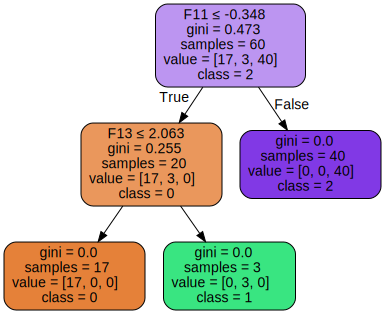

In [49]:
# Addestro l'albero di decisione
clf = tree.DecisionTreeClassifier()#(max_depth=10)
clf = clf.fit(X_train, y_train)

# Eseguo il plot dell'albero di decisione creato
dot_data = tree.export_graphviz(clf, out_file=None,
    feature_names=reshaped_features_names,
    class_names=clustering_labels, #['Ugo', 'Federico', 'D.Va'],
    filled=True, rounded=True,
    special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [50]:
# Predico con l'albero di decisione
y_pred = clf.predict(X_test)
print("DT - Predictions:\n", y_pred)

DT - Predictions:
 [2 2]


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=81dda25b-3b1c-4959-acc8-4a8b980be717' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>